In [10]:
pip install torch torchvision scikit-learn matplotlib opencv-python tqdm

Note: you may need to restart the kernel to use updated packages.


In [11]:
import os
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
from PIL import Image
image = Image.open('train/benign/3.jpg')
image.show()

QObject::moveToThread: Current thread (0x60977b2c53d0) is not the object's thread (0x60977b2daec0).
Cannot move to target thread (0x60977b2c53d0)

qt.qpa.plugin: Could not load the Qt platform plugin "xcb" in "/home/sayan/miniconda3/envs/pytorch_env/lib/python3.11/site-packages/cv2/qt/plugins" even though it was found.
This application failed to start because no Qt platform plugin could be initialized. Reinstalling the application may fix this problem.

Available platform plugins are: xcb, eglfs, linuxfb, minimal, minimalegl, offscreen, vnc, wayland-egl, wayland, wayland-xcomposite-egl, wayland-xcomposite-glx.

Aborted (core dumped)


In [14]:
img_array = np.asarray(image)
image_height = len(img_array)
image_width = len(img_array[0])
print("Image Dimension")
print(image_height, "X" ,image_width)


Image Dimension
224 X 224


In [15]:
import os

#DATA_DIR = "/home/sayan/Downloads/Medical Imagining (CT scan, MRI, X-ray, and Microscopic Imagery) Data/Medical Imagining/Skin Lesions Classification"  # change this
DATA_DIR = "."
print("DATA_DIR exists:", os.path.exists(DATA_DIR))
print("Train exists:", os.path.exists(os.path.join(DATA_DIR, "train")))
print("Test exists:", os.path.exists(os.path.join(DATA_DIR, "test")))

DATA_DIR exists: True
Train exists: True
Test exists: True


In [16]:
DATA_DIR = "."  # change this
TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR = os.path.join(DATA_DIR, "test")

In [17]:
IMG_SIZE = 224

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomRotation(degrees=20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [18]:
train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=train_transform)
test_dataset = datasets.ImageFolder(TEST_DIR, transform=test_transform)

print("Class mapping:", train_dataset.class_to_idx)


Class mapping: {'benign': 0, 'malignant': 1}


In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [20]:
BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                          shuffle=True, num_workers=2)

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                         shuffle=False, num_workers=2)


In [23]:
from torchvision import models
import torch.nn as nn

model = models.resnet50(pretrained=True)

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)

model = model.to(device)
print(model)


/home/sayan/miniconda3/envs/pytorch_env/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sayan/miniconda3/envs/pytorch_env/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [24]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.0001)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

In [31]:
import copy
import torch
from tqdm import tqdm

def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, epochs=20):
    best_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())

    train_losses, test_losses = [], []
    train_accs, test_accs = [], []

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        print("-" * 40)

        # ---------------- TRAIN ----------------
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in tqdm(train_loader, desc="Training"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            preds = torch.argmax(outputs, dim=1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / total
        train_acc = correct / total

        # ---------------- TEST ----------------
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in tqdm(test_loader, desc="Testing"):
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                running_loss += loss.item() * images.size(0)
                preds = torch.argmax(outputs, dim=1)

                correct += (preds == labels).sum().item()
                total += labels.size(0)

        test_loss = running_loss / total
        test_acc = correct / total

        # Step scheduler
        scheduler.step()

        # Store history
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accs.append(train_acc)
        test_accs.append(test_acc)

        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"Test Loss : {test_loss:.4f} | Test Acc : {test_acc:.4f}")

        # Save best model
        if test_acc > best_acc:
            best_acc = test_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), "best_skin_lesion_model.pth")
            print("✅ Best model saved!")

    model.load_state_dict(best_model_wts)

    history = {
        "train_losses": train_losses,
        "test_losses": test_losses,
        "train_accs": train_accs,
        "test_accs": test_accs
    }

    return model, history

In [35]:
print(type(model))

<class 'tuple'>


In [36]:
model = model[0]   # extract only the model from (model, history)

In [37]:
EPOCHS = 20
model, history = train_model(model, train_loader, test_loader,
                             criterion, optimizer, scheduler,
                             epochs=EPOCHS)


Epoch 1/20
----------------------------------------


Testing: 100%|██████████| 21/21 [00:02<00:00,  9.73it/s]


Train Loss: 0.0198 | Train Acc: 0.9939
Test Loss : 0.3324 | Test Acc : 0.9030
✅ Best model saved!

Epoch 2/20
----------------------------------------


Testing: 100%|██████████| 21/21 [00:02<00:00,  9.85it/s]


Train Loss: 0.0216 | Train Acc: 0.9920
Test Loss : 0.3111 | Test Acc : 0.9076
✅ Best model saved!

Epoch 3/20
----------------------------------------


Testing: 100%|██████████| 21/21 [00:02<00:00,  9.63it/s]


Train Loss: 0.0184 | Train Acc: 0.9947
Test Loss : 0.2928 | Test Acc : 0.9106
✅ Best model saved!

Epoch 4/20
----------------------------------------


Testing: 100%|██████████| 21/21 [00:02<00:00,  9.76it/s]


Train Loss: 0.0163 | Train Acc: 0.9954
Test Loss : 0.2931 | Test Acc : 0.9061

Epoch 5/20
----------------------------------------


Testing: 100%|██████████| 21/21 [00:02<00:00,  9.68it/s]


Train Loss: 0.0190 | Train Acc: 0.9943
Test Loss : 0.2988 | Test Acc : 0.9121
✅ Best model saved!

Epoch 6/20
----------------------------------------


Testing: 100%|██████████| 21/21 [00:02<00:00,  9.70it/s]


Train Loss: 0.0156 | Train Acc: 0.9951
Test Loss : 0.2982 | Test Acc : 0.9136
✅ Best model saved!

Epoch 7/20
----------------------------------------


Testing: 100%|██████████| 21/21 [00:02<00:00,  9.54it/s]


Train Loss: 0.0187 | Train Acc: 0.9936
Test Loss : 0.3009 | Test Acc : 0.9061

Epoch 8/20
----------------------------------------


Testing: 100%|██████████| 21/21 [00:02<00:00,  9.67it/s]


Train Loss: 0.0139 | Train Acc: 0.9966
Test Loss : 0.3066 | Test Acc : 0.9091

Epoch 9/20
----------------------------------------


Testing: 100%|██████████| 21/21 [00:02<00:00,  9.72it/s]


Train Loss: 0.0192 | Train Acc: 0.9943
Test Loss : 0.3083 | Test Acc : 0.9076

Epoch 10/20
----------------------------------------


Testing: 100%|██████████| 21/21 [00:02<00:00,  9.72it/s]


Train Loss: 0.0182 | Train Acc: 0.9932
Test Loss : 0.3277 | Test Acc : 0.9076

Epoch 11/20
----------------------------------------


Testing: 100%|██████████| 21/21 [00:02<00:00,  9.68it/s]


Train Loss: 0.0167 | Train Acc: 0.9958
Test Loss : 0.3201 | Test Acc : 0.9091

Epoch 12/20
----------------------------------------


Testing: 100%|██████████| 21/21 [00:02<00:00,  9.66it/s]


Train Loss: 0.0125 | Train Acc: 0.9962
Test Loss : 0.3191 | Test Acc : 0.9106

Epoch 13/20
----------------------------------------


Testing: 100%|██████████| 21/21 [00:02<00:00,  9.74it/s]


Train Loss: 0.0157 | Train Acc: 0.9958
Test Loss : 0.3137 | Test Acc : 0.9045

Epoch 14/20
----------------------------------------


Testing: 100%|██████████| 21/21 [00:02<00:00,  9.73it/s]


Train Loss: 0.0136 | Train Acc: 0.9962
Test Loss : 0.3100 | Test Acc : 0.9121

Epoch 15/20
----------------------------------------


Testing: 100%|██████████| 21/21 [00:02<00:00,  9.73it/s]


Train Loss: 0.0175 | Train Acc: 0.9951
Test Loss : 0.3152 | Test Acc : 0.9091

Epoch 16/20
----------------------------------------


Testing: 100%|██████████| 21/21 [00:02<00:00,  9.72it/s]


Train Loss: 0.0171 | Train Acc: 0.9951
Test Loss : 0.3167 | Test Acc : 0.9076

Epoch 17/20
----------------------------------------


Testing: 100%|██████████| 21/21 [00:02<00:00,  9.73it/s]


Train Loss: 0.0154 | Train Acc: 0.9947
Test Loss : 0.3041 | Test Acc : 0.9045

Epoch 18/20
----------------------------------------


Testing: 100%|██████████| 21/21 [00:02<00:00,  9.72it/s]


Train Loss: 0.0178 | Train Acc: 0.9943
Test Loss : 0.3047 | Test Acc : 0.9106

Epoch 19/20
----------------------------------------


Testing: 100%|██████████| 21/21 [00:02<00:00,  9.71it/s]


Train Loss: 0.0167 | Train Acc: 0.9970
Test Loss : 0.3185 | Test Acc : 0.9076

Epoch 20/20
----------------------------------------


Testing: 100%|██████████| 21/21 [00:02<00:00,  9.80it/s]

Train Loss: 0.0144 | Train Acc: 0.9966
Test Loss : 0.3146 | Test Acc : 0.9091


In [38]:
import numpy as np
import torch
from sklearn.metrics import classification_report, confusion_matrix

def evaluate_model(model, loader):
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)

            outputs = model(images)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()

            all_preds.extend(preds)
            all_labels.extend(labels.numpy())

    return np.array(all_labels), np.array(all_preds)

y_true, y_pred = evaluate_model(model, test_loader)

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=test_dataset.classes))

print("\nConfusion Matrix:\n")
print(confusion_matrix(y_true, y_pred))
cm = confusion_matrix(y_true, y_pred)

print("\n✅ Class-wise Accuracy:")
for i, class_name in enumerate(test_dataset.classes):
    class_acc = cm[i, i] / cm[i, :].sum()
    print(f"{class_name}: {class_acc:.4f}  ({cm[i,i]}/{cm[i,:].sum()})")


Classification Report:

              precision    recall  f1-score   support

      benign       0.94      0.90      0.92       360
   malignant       0.89      0.93      0.91       300

    accuracy                           0.91       660
   macro avg       0.91      0.92      0.91       660
weighted avg       0.91      0.91      0.91       660


Confusion Matrix:

[[324  36]
 [ 21 279]]

✅ Class-wise Accuracy:
benign: 0.9000  (324/360)
malignant: 0.9300  (279/300)


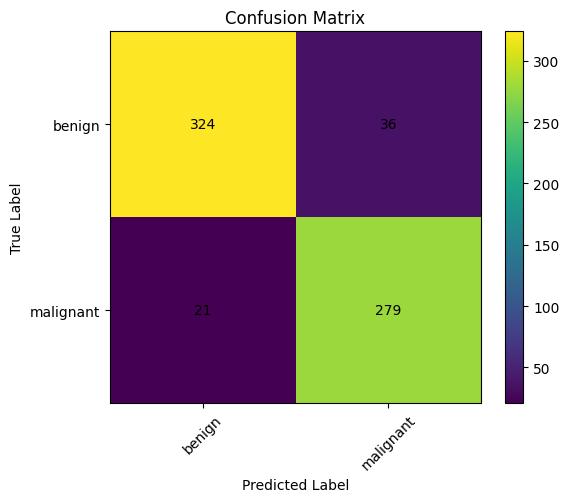

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(6, 5))
    plt.imshow(cm)
    plt.title("Confusion Matrix")
    plt.colorbar()

    ticks = np.arange(len(class_names))
    plt.xticks(ticks, class_names, rotation=45)
    plt.yticks(ticks, class_names)

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], ha="center", va="center")

    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()

    return cm
cm = plot_confusion_matrix(y_true, y_pred, test_dataset.classes)

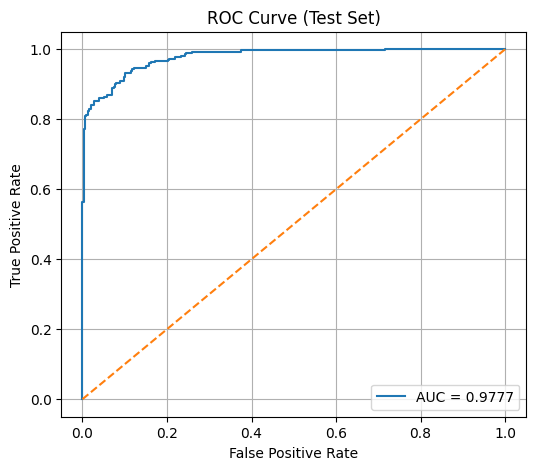

✅ Test AUC: 0.9777


In [42]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(model, loader):
    model.eval()

    all_probs = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)

            outputs = model(images)  # logits
            probs = torch.softmax(outputs, dim=1)[:, 1]  # prob of class 1

            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.numpy())

    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)

    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve (Test Set)")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    print(f"✅ Test AUC: {roc_auc:.4f}")
plot_roc_curve(model, test_loader)

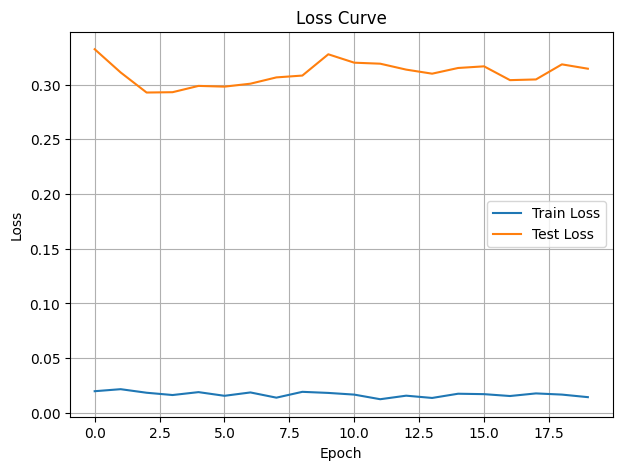

In [44]:
def plot_loss_curve(history):
    train_losses = history["train_losses"]
    test_losses = history["test_losses"]

    plt.figure(figsize=(7, 5))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(test_losses, label="Test Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Curve")
    plt.legend()
    plt.grid(True)
    plt.show()
plot_loss_curve(history)

In [47]:
print(history["train_losses"][-5:])
print(history["test_losses"][-5:])

[0.017103932217465607, 0.015396760753682607, 0.017780329369553843, 0.016702585429914513, 0.014359838025525049]
[0.31673227589450437, 0.30411489062067687, 0.3047476887152615, 0.31853657537351615, 0.31456100665046977]


In [45]:
print(history["train_losses"])

[0.01979183894891121, 0.021640138040873468, 0.018392309973106088, 0.016298604739923842, 0.01895207927728642, 0.015594617754841137, 0.018664065835863962, 0.01389391491861338, 0.019222757844399176, 0.018228046248526024, 0.016684642936758892, 0.012468730782892923, 0.015706975886132568, 0.013631527518707331, 0.01748992266733119, 0.017103932217465607, 0.015396760753682607, 0.017780329369553843, 0.016702585429914513, 0.014359838025525049]


In [48]:
for i, (tr, te) in enumerate(zip(history["train_losses"], history["test_losses"])):
    print(f"Epoch {i+1}: Train Loss={tr:.6f}, Test Loss={te:.6f}")

Epoch 1: Train Loss=0.019792, Test Loss=0.332371
Epoch 2: Train Loss=0.021640, Test Loss=0.311142
Epoch 3: Train Loss=0.018392, Test Loss=0.292786
Epoch 4: Train Loss=0.016299, Test Loss=0.293090
Epoch 5: Train Loss=0.018952, Test Loss=0.298844
Epoch 6: Train Loss=0.015595, Test Loss=0.298177
Epoch 7: Train Loss=0.018664, Test Loss=0.300864
Epoch 8: Train Loss=0.013894, Test Loss=0.306618
Epoch 9: Train Loss=0.019223, Test Loss=0.308291
Epoch 10: Train Loss=0.018228, Test Loss=0.327742
Epoch 11: Train Loss=0.016685, Test Loss=0.320065
Epoch 12: Train Loss=0.012469, Test Loss=0.319144
Epoch 13: Train Loss=0.015707, Test Loss=0.313732
Epoch 14: Train Loss=0.013632, Test Loss=0.310019
Epoch 15: Train Loss=0.017490, Test Loss=0.315221
Epoch 16: Train Loss=0.017104, Test Loss=0.316732
Epoch 17: Train Loss=0.015397, Test Loss=0.304115
Epoch 18: Train Loss=0.017780, Test Loss=0.304748
Epoch 19: Train Loss=0.016703, Test Loss=0.318537
Epoch 20: Train Loss=0.014360, Test Loss=0.314561


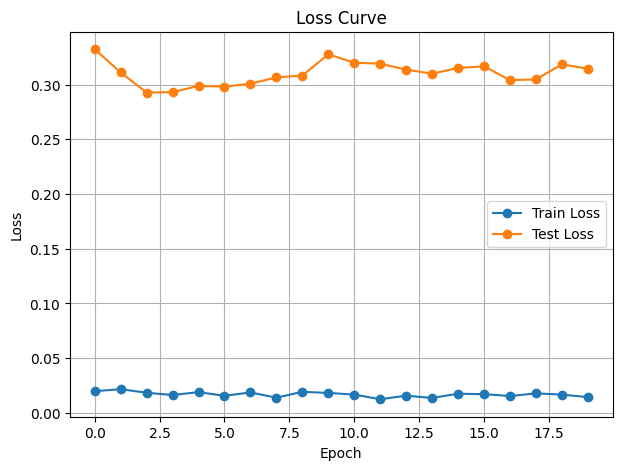

In [49]:
plt.figure(figsize=(7,5))
plt.plot(history["train_losses"], marker="o", label="Train Loss")
plt.plot(history["test_losses"], marker="o", label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.grid(True)
plt.show()

In [39]:
MISCLASS_DIR = "misclassified"
os.makedirs(MISCLASS_DIR, exist_ok=True)

model.eval()

for idx in range(len(test_dataset)):
    img, label = test_dataset[idx]

    img_batch = img.unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(img_batch)
        pred = torch.argmax(output, dim=1).item()

    if pred != label:
        path, _ = test_dataset.samples[idx]
        filename = os.path.basename(path)

        class_name = test_dataset.classes[label]
        pred_name = test_dataset.classes[pred]

        save_path = os.path.join(MISCLASS_DIR, f"true_{class_name}_pred_{pred_name}_{filename}")
        cv2.imwrite(save_path, cv2.imread(path))


In [55]:
import torch

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Forward hook
        self.target_layer.register_forward_hook(self.save_activation)

        # Backward hook (new safe version)
        self.target_layer.register_full_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate(self, input_tensor, class_idx=None):
        self.model.eval()

        output = self.model(input_tensor)

        if class_idx is None:
            class_idx = torch.argmax(output, dim=1).item()

        self.model.zero_grad()
        loss = output[0, class_idx]
        loss.backward()

        gradients = self.gradients[0]     # [C,H,W]
        activations = self.activations[0] # [C,H,W]

        # GAP over gradients → weights
        weights = torch.mean(gradients, dim=(1, 2))  # [C]

        cam = torch.zeros(activations.shape[1:], device=input_tensor.device)

        for i, w in enumerate(weights):
            cam += w * activations[i]

        cam = torch.relu(cam)

        # Normalize safely
        cam -= cam.min()
        cam /= (cam.max() + 1e-8)

        return cam.detach().cpu().numpy()
gradcam = GradCAM(model, model.layer4)


In [57]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from torchvision import transforms

# pick an image from test dataset
idx = 5  # change this

img, label = test_dataset[idx]   # img shape: [3,224,224]
input_tensor = img.unsqueeze(0).to(device)

# GradCAM
gradcam = GradCAM(model, model.layer4)

# malignant class = 1, benign class = 0
cam = gradcam.generate(input_tensor, class_idx=1)

print("True label:", test_dataset.classes[label])

True label: benign


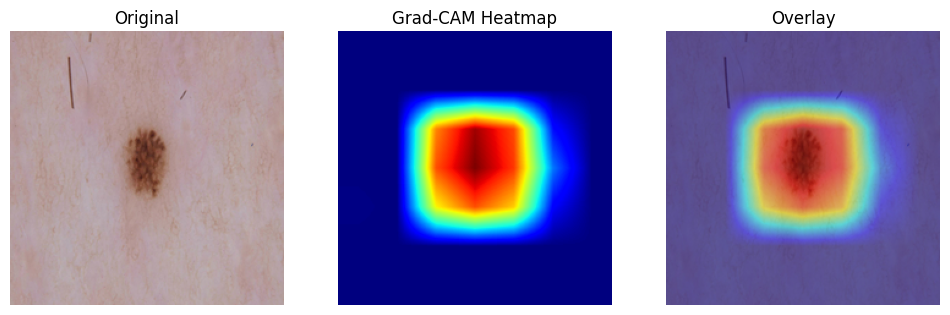

In [58]:
# Inverse normalize for display
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

img_np = inv_normalize(img).permute(1, 2, 0).cpu().numpy()
img_np = np.clip(img_np, 0, 1)

cam_resized = cv2.resize(cam, (IMG_SIZE, IMG_SIZE))
heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB) / 255.0

overlay = 0.5 * img_np + 0.5 * heatmap
overlay = np.clip(overlay, 0, 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("Original")
plt.imshow(img_np)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Grad-CAM Heatmap")
plt.imshow(cam_resized, cmap="jet")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Overlay")
plt.imshow(overlay)
plt.axis("off")

plt.show()

In [59]:
cam = gradcam.generate(input_tensor)

## Improving accuracy by fine tuning ResNet50

In [34]:
import torch
import torch.nn as nn
from torchvision import models

model = models.resnet50(pretrained=True)

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)

model = model.to(device)

/home/sayan/miniconda3/envs/pytorch_env/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sayan/miniconda3/envs/pytorch_env/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [60]:
def freeze_all(model):
    for param in model.parameters():
        param.requires_grad = False

def unfreeze_layer(model, layer_name):
    for name, param in model.named_parameters():
        if layer_name in name:
            param.requires_grad = True

def unfreeze_all(model):
    for param in model.parameters():
        param.requires_grad = True

In [61]:
import copy
from tqdm import tqdm

def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, epochs=5, patience=3):
    best_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())
    counter = 0

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        print("-" * 40)

        # TRAIN
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in tqdm(train_loader, desc="Training"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / total
        train_acc = correct / total

        # TEST
        model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in tqdm(test_loader, desc="Testing"):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                preds = torch.argmax(outputs, dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        test_acc = correct / total

        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"Test Acc: {test_acc:.4f}")

        scheduler.step()

        # Save best model
        if test_acc > best_acc:
            best_acc = test_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), "best_skin_resnet50_finetuned.pth")
            print("✅ Best model saved!")
            counter = 0
        else:
            counter += 1
            print(f"⚠️ No improvement. EarlyStop counter: {counter}/{patience}")

        # Early stopping
        if counter >= patience:
            print("⛔ Early stopping triggered!")
            break

    model.load_state_dict(best_model_wts)
    return model

In [ ]:
freeze_all(model)

unfreeze_layer(model, "layer3")
unfreeze_layer(model, "layer4")
for param in model.fc.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=5e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

model = train_model(
    model,
    train_loader,
    test_loader,
    criterion,
    optimizer,
    scheduler,
    epochs=10,
    patience=2
)


Epoch 1/10
----------------------------------------


Testing: 100%|██████████| 21/21 [00:02<00:00,  7.86it/s]


Train Loss: 0.1311 | Train Acc: 0.9477
Test Acc: 0.8939
✅ Best model saved!

Epoch 2/10
----------------------------------------


Testing: 100%|██████████| 21/21 [00:02<00:00,  7.99it/s]


Train Loss: 0.0955 | Train Acc: 0.9613
Test Acc: 0.9152
✅ Best model saved!

Epoch 3/10
----------------------------------------


Testing: 100%|██████████| 21/21 [00:02<00:00,  8.14it/s]


Train Loss: 0.0952 | Train Acc: 0.9670
Test Acc: 0.9121
⚠️ No improvement. EarlyStop counter: 1/2

Epoch 4/10
----------------------------------------


Testing: 100%|██████████| 21/21 [00:02<00:00,  8.02it/s]


Train Loss: 0.0639 | Train Acc: 0.9754
Test Acc: 0.9197
✅ Best model saved!

Epoch 5/10
----------------------------------------


Testing: 100%|██████████| 21/21 [00:02<00:00,  8.17it/s]


Train Loss: 0.0531 | Train Acc: 0.9784
Test Acc: 0.9136
⚠️ No improvement. EarlyStop counter: 1/2

Epoch 6/10
----------------------------------------


Testing: 100%|██████████| 21/21 [00:02<00:00,  8.18it/s]


Train Loss: 0.0502 | Train Acc: 0.9833
Test Acc: 0.9227
✅ Best model saved!

Epoch 7/10
----------------------------------------


Testing: 100%|██████████| 21/21 [00:02<00:00,  8.24it/s]


Train Loss: 0.0410 | Train Acc: 0.9863
Test Acc: 0.9273
✅ Best model saved!

Epoch 8/10
----------------------------------------


Testing: 100%|██████████| 21/21 [00:02<00:00,  8.01it/s]


Train Loss: 0.0389 | Train Acc: 0.9845
Test Acc: 0.9258
⚠️ No improvement. EarlyStop counter: 1/2

Epoch 9/10
----------------------------------------


Testing: 100%|██████████| 21/21 [00:02<00:00,  8.40it/s]


Train Loss: 0.0247 | Train Acc: 0.9932
Test Acc: 0.9303
✅ Best model saved!

Epoch 10/10
----------------------------------------


Testing: 100%|██████████| 21/21 [00:02<00:00,  8.04it/s]

Train Loss: 0.0259 | Train Acc: 0.9920
Test Acc: 0.9242
⚠️ No improvement. EarlyStop counter: 1/2


# Training: 100%|██████████| 83/83 [00:15<00:00,  5.29it/s]
# Testing: 100%|██████████| 21/21 [00:02<00:00,  8.40it/s]
# Train Loss: 0.0247 | Train Acc: 0.9932
# Test Acc: 0.9303
# Best model saved!

In [5]:
import torch
import torch.nn as nn
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet50(pretrained=False)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)

model.load_state_dict(torch.load("best_skin_resnet50_finetuned.pth", map_location=device))
model = model.to(device)
model.eval()

print("✅ Best model loaded successfully!")

/home/sayan/miniconda3/envs/pytorch_env/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sayan/miniconda3/envs/pytorch_env/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


✅ Best model loaded successfully!


In [6]:
import numpy as np

def get_predictions(model, loader):
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)

            outputs = model(images)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()

            all_preds.extend(preds)
            all_labels.extend(labels.numpy())

    return np.array(all_labels), np.array(all_preds)


In [7]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(6, 5))
    plt.imshow(cm, interpolation="nearest")
    plt.title("Confusion Matrix")
    plt.colorbar()

    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], ha="center", va="center")

    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.show()

    return cm



Classification Report:

              precision    recall  f1-score   support

      benign       0.94      0.93      0.94       360
   malignant       0.92      0.93      0.92       300

    accuracy                           0.93       660
   macro avg       0.93      0.93      0.93       660
weighted avg       0.93      0.93      0.93       660



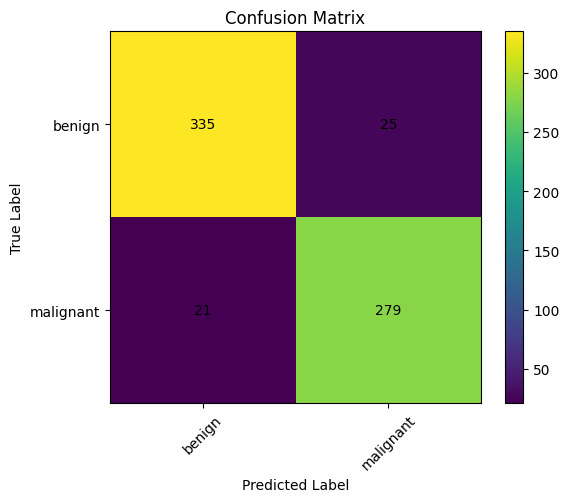


Confusion Matrix:
 [[335  25]
 [ 21 279]]


In [21]:
y_true, y_pred = get_predictions(model, test_loader)

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=test_dataset.classes))

cm = plot_confusion_matrix(y_true, y_pred, test_dataset.classes)

print("\nConfusion Matrix:\n", cm)

In [22]:
import numpy as np
from sklearn.metrics import confusion_matrix

def class_wise_accuracy(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)

    print("\nConfusion Matrix:\n", cm)

    print("\nClass-wise Accuracy:")
    for i, class_name in enumerate(class_names):
        correct = cm[i, i]
        total = cm[i, :].sum()
        acc = correct / total
        print(f"{class_name}: {acc:.4f}  ({correct}/{total})")

    overall_acc = np.trace(cm) / np.sum(cm)
    print(f"\nOverall Accuracy: {overall_acc:.4f}")

# Run
class_wise_accuracy(y_true, y_pred, test_dataset.classes)



Confusion Matrix:
 [[335  25]
 [ 21 279]]

Class-wise Accuracy:
benign: 0.9306  (335/360)
malignant: 0.9300  (279/300)

Overall Accuracy: 0.9303


## Machine Learning

In [62]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from skimage.feature import graycomatrix, graycoprops
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler

# Constants
IMG_SIZE = 128
CATEGORIES = ['benign', 'malignant']

def preprocess_image(path):
    # Load image
    img = cv2.imread(path)
    if img is None:
        return None
    
    # 2. Preprocessing: Resize and Denoising
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    
    # Gaussian Blur for noise removal
    img_blurred = cv2.GaussianBlur(img, (5, 5), 0)
    
    # Convert to Grayscale for feature extraction
    gray = cv2.cvtColor(img_blurred, cv2.COLOR_BGR2GRAY)
    
    # Normalize intensity values (0 to 1)
    normalized_img = gray / 255.0
    return normalized_img

def augment_data(img):
    # 3. Data Augmentation (Flipping and Rotation)
    augmented = []
    augmented.append(img)
    augmented.append(cv2.flip(img, 1)) # Horizontal flip
    # Simple 90 degree rotation
    rows, cols = img.shape
    M = cv2.getRotationMatrix2D((cols/2, rows/2), 90, 1)
    augmented.append(cv2.warpAffine(img, M, (cols, rows)))
    return augmented

In [63]:
def extract_features(img):
    # Ensure image is in 8-bit for GLCM
    img_8bit = (img * 255).astype(np.uint8)
    
    # 4. Feature Extraction: GLCM
    # Distance=1, Angle=0 degrees
    glcm = graycomatrix(img_8bit, [1], [0], 256, symmetric=True, normed=True)
    
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    dissimilarity = graycoprops(glcm, 'dissimilarity')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    
    # 5. Numerical Feature Vector
    # Combine GLCM with basic intensity statistics (Mean, Std Dev)
    mean_val = np.mean(img)
    std_val = np.std(img)
    
    return [contrast, dissimilarity, homogeneity, energy, correlation, mean_val, std_val]

In [64]:
def load_dataset(data_dir, augment=False):
    features = []
    labels = []
    
    for category in CATEGORIES:
        path = os.path.join(data_dir, category)
        class_num = CATEGORIES.index(category)
        
        for img_name in tqdm(os.listdir(path)):
            img_path = os.path.join(path, img_name)
            processed = preprocess_image(img_path)
            
            if processed is not None:
                if augment:
                    versions = augment_data(processed)
                    for v in versions:
                        features.append(extract_features(v))
                        labels.append(class_num)
                else:
                    features.append(extract_features(processed))
                    labels.append(class_num)
                    
    return np.array(features), np.array(labels)

# Main Execution
print("Loading Training Data...")
X_train, y_train = load_dataset('train', augment=True)
print("Loading Test Data...")
X_test, y_test = load_dataset('test', augment=False)

# Scaling features for SVM
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 6. Train Classifier (SVM)
clf = SVC(kernel='rbf', C=1.0, gamma='scale')
clf.fit(X_train, y_train)

# 7. Evaluation
y_pred = clf.predict(X_test)

print("\n--- Model Evaluation ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=CATEGORIES))

Loading Training Data...


100%|██████████| 1197/1197 [00:07<00:00, 159.69it/s]


Loading Test Data...


100%|██████████| 300/300 [00:00<00:00, 392.50it/s]



--- Model Evaluation ---
Accuracy: 0.79

Confusion Matrix:
[[282  78]
 [ 63 237]]

Classification Report:
              precision    recall  f1-score   support

      benign       0.82      0.78      0.80       360
   malignant       0.75      0.79      0.77       300

    accuracy                           0.79       660
   macro avg       0.78      0.79      0.79       660
weighted avg       0.79      0.79      0.79       660



In [65]:
from sklearn.ensemble import RandomForestClassifier

# 6. Train Random Forest Classifier
# n_estimators=100 creates an ensemble of 100 decision trees
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_clf.fit(X_train, y_train)

# 7. Evaluation
y_pred = rf_clf.predict(X_test)

print("\n--- Random Forest Evaluation ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Feature Importance Mapping
feature_names = ['Contrast', 'Dissimilarity', 'Homogeneity', 'Energy', 'Correlation', 'Mean', 'Std Dev']
importances = rf_clf.feature_importances_

print("\n--- Feature Importances ---")
for name, importance in zip(feature_names, importances):
    print(f"{name}: {importance:.4f}")


--- Random Forest Evaluation ---
Accuracy: 0.76

Confusion Matrix:
[[263  97]
 [ 60 240]]

--- Feature Importances ---
Contrast: 0.1618
Dissimilarity: 0.1631
Homogeneity: 0.1477
Energy: 0.1409
Correlation: 0.1461
Mean: 0.1216
Std Dev: 0.1188


In [66]:
from sklearn.linear_model import LogisticRegression

# 6. Train Logistic Regression Classifier
# 'liblinear' is a good solver for small-to-medium datasets
log_reg = LogisticRegression(solver='liblinear', max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)

# 7. Evaluation
y_pred = log_reg.predict(X_test)
y_prob = log_reg.predict_proba(X_test)[:, 1] # Probability for the malignant class

print("\n--- Logistic Regression Evaluation ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")

# Confusion Matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Coefficients (Feature Importance)
feature_names = ['Contrast', 'Dissimilarity', 'Homogeneity', 'Energy', 'Correlation', 'Mean', 'Std Dev']
print("\n--- Model Coefficients (Impact on Prediction) ---")
for name, coef in zip(feature_names, log_reg.coef_[0]):
    print(f"{name}: {coef:.4f}")


--- Logistic Regression Evaluation ---
Accuracy: 0.75

Confusion Matrix:
[[264  96]
 [ 70 230]]

--- Model Coefficients (Impact on Prediction) ---
Contrast: 0.8849
Dissimilarity: -1.5571
Homogeneity: -1.7484
Energy: 0.3048
Correlation: -0.7426
Mean: 0.0255
Std Dev: 0.4007


In [69]:
import joblib
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# 1. Define and Train (Make sure these lines run!)
svm_model = SVC(kernel='rbf', probability=True)
svm_model.fit(X_train, y_train)

rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train, y_train)

log_reg_model = LogisticRegression(max_iter=1000)
log_reg_model.fit(X_train, y_train)

# 2. Now save them
joblib.dump(svm_model, 'svm_skin_model.pkl')
joblib.dump(rf_model, 'rf_skin_model.pkl')
joblib.dump(log_reg_model, 'log_reg_skin_model.pkl')
joblib.dump(scaler, 'scaler.pkl') # Don't forget the scaler!

print("Models saved successfully.")

Models saved successfully.
